# Masquerade Detection

#### Introduction

#### Data

#### Method

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers, Sequential, preprocessing

In [2]:
#create directory to store model
!mkdir '/Users/ositanwegbu/Documents/GitHub/Masquerade_detection/Model/'

In [3]:
IMAGE_SIZE = 128, 128
BATCH_SIZE = 32
CHANNELS   = 3  

In [4]:
dataset = preprocessing.image_dataset_from_directory(
    'Mmanwu',
    shuffle = True,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
)

Found 1741 files belonging to 2 classes.


In [5]:
class_names = dataset.class_names
class_names

['No_masquerade', 'masquerade']

In [6]:
#view shape of image batch
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch)

(32, 128, 128, 3)
tf.Tensor([1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1], shape=(32,), dtype=int32)


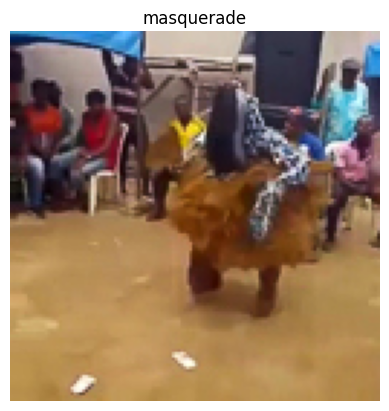

In [7]:
#view a sample image
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

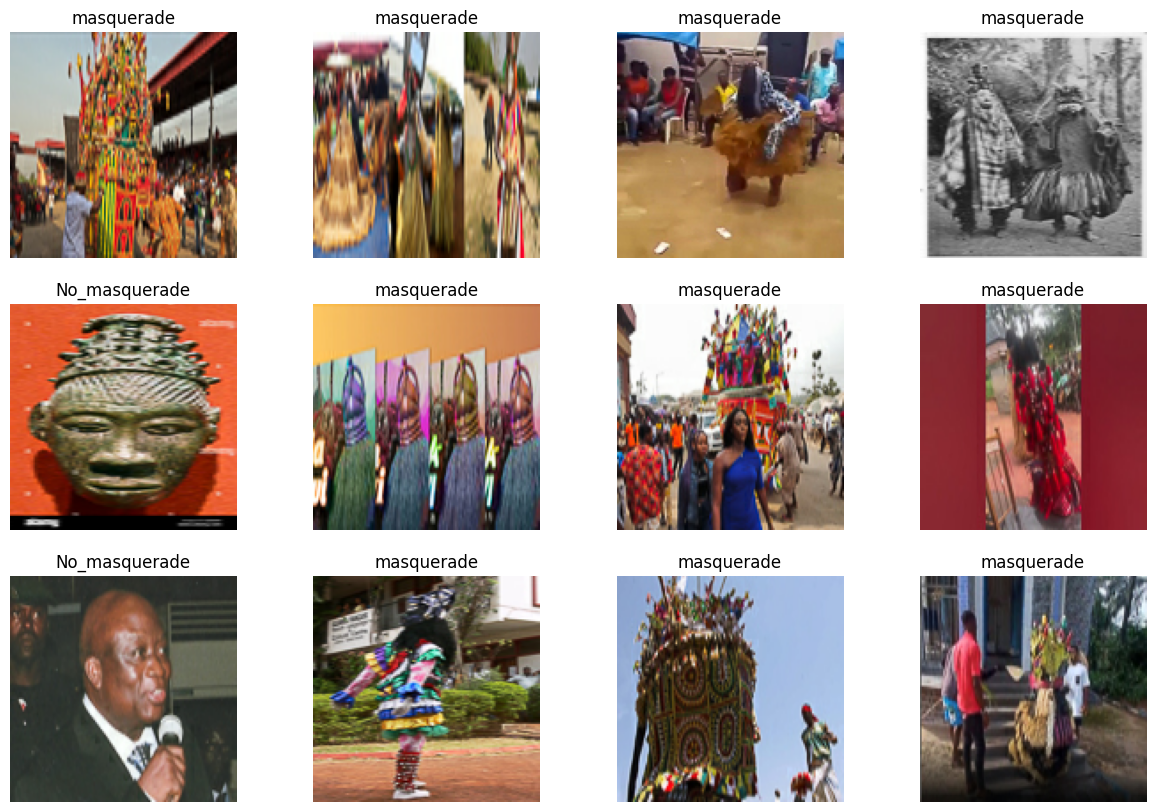

In [8]:
#View a few random selection of images
plt.figure(figsize=(15,10))

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off");

In [9]:
#split the data into train/test partitions

def get_dataset_partition(ds, train_split=0.8, val_split=0.1, test_split = 0.1, shuffle=True, shuffle_size = 1000):
    
    #get size of the dataset
    ds_size = 0
    for i in ds:
        ds_size+=1
        
    #shuffle the dataset
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 20)
        
    #Get size of the train dataset
    train_size = int(train_split * ds_size)
    val_size  = int(val_split * ds_size)
    
    #Get Train dataset
    train_ds = ds.take(train_size)
    
    #Get test dataset
    val_ds  = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    return train_ds, val_ds, test_ds

In [10]:
#Partition the data
train_ds, val_ds, test_ds = get_dataset_partition(dataset)
print(f"The size of the Training dataset - > {len(train_ds)}")
print(f"The size of the Validation dataset - > {len(val_ds)}")
print(f"The size of the Test dataset - > {len(test_ds)}")

The size of the Training dataset - > 44
The size of the Validation dataset - > 5
The size of the Test dataset - > 6


In [11]:
# Use cache abnd prefetch for loading the data
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
##### Create custom layers to resize/rescale
resize_and_rescale = Sequential([
    layers.experimental.preprocessing.Resizing(128,128),
    layers.experimental.preprocessing.Rescaling(1.0/255)])

In [13]:
data_augmentation = Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)])

## Model development

In [14]:
IMAGE_SIZE  = 128
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2
epochs = 50

In [15]:
model = Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (2,2), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (2,2), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (2,2), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (2,2), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (2,2), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

In [16]:
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 128, 128, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 128, 128, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 127, 127, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2  (32, 63, 63, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 62, 62, 128)         16512     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 31, 31, 128)         0         
 g2D)                                                 

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["Accuracy"]
)

In [18]:
history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
44/44 [==============================] - 5s 100ms/step - loss: 0.6329 - Accuracy: 0.7034 - val_loss: 0.6494 - val_Accuracy: 0.6562
Epoch 2/50
44/44 [==============================] - 4s 96ms/step - loss: 0.6112 - Accuracy: 0.7127 - val_loss: 0.6593 - val_Accuracy: 0.6562
Epoch 3/50
44/44 [==============================] - 4s 96ms/step - loss: 0.5769 - Accuracy: 0.7293 - val_loss: 0.6064 - val_Accuracy: 0.6750
Epoch 4/50
44/44 [==============================] - 4s 97ms/step - loss: 0.5649 - Accuracy: 0.7415 - val_loss: 0.5805 - val_Accuracy: 0.7000
Epoch 5/50
44/44 [==============================] - 4s 98ms/step - loss: 0.5596 - Accuracy: 0.7394 - val_loss: 0.6348 - val_Accuracy: 0.6875
Epoch 6/50
44/44 [==============================] - 4s 99ms/step - loss: 0.5693 - Accuracy: 0.7315 - val_loss: 0.6441 - val_Accuracy: 0.6812
Epoch 7/50
44/44 [==============================] - 4s 97ms/step - loss: 0.5643 - Accuracy: 0.7423 - val_loss: 0.6058 - val_Accuracy: 0.6875
Epoch 8/50
4

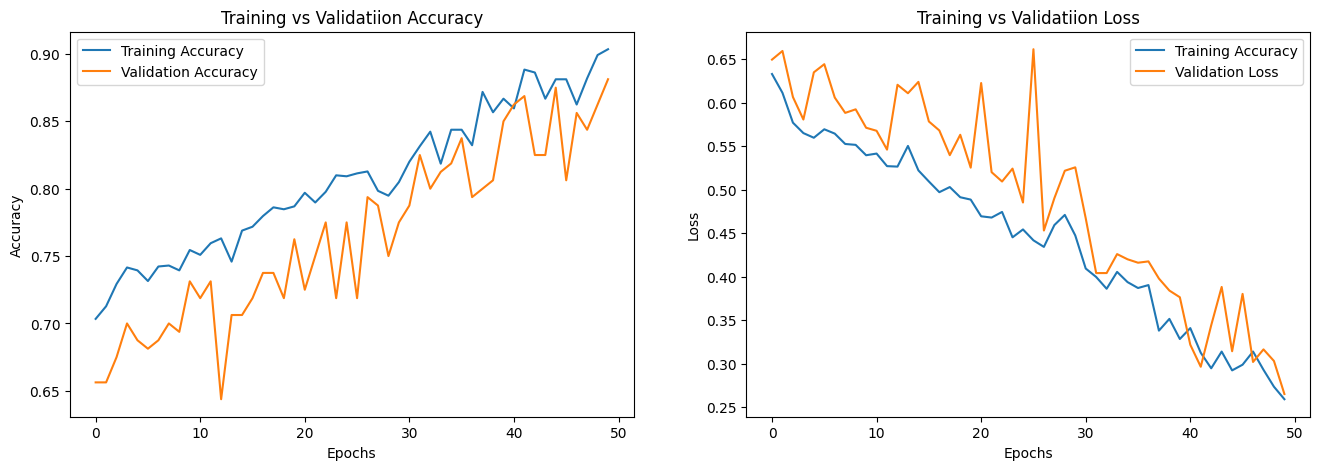

In [19]:
#plot performance 
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.title('Training vs Validatiion Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Accuracy','Validation Loss'])
plt.title('Training vs Validatiion Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Image to predict
Image actual label: masquerade
predicted image label: masquerade


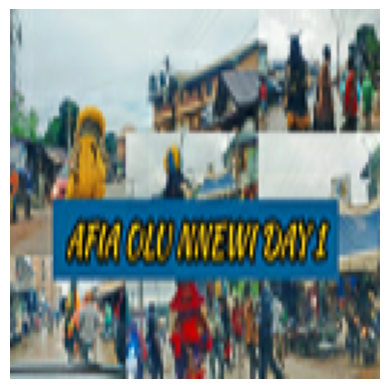

In [20]:
#Test our model

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('Image to predict')
    plt.imshow(first_image)
    plt.axis("off")
    
    print('Image actual label:', class_names[first_label])
    
    batch_prediction = model.predict(images_batch, verbose=0)
    print("predicted image label:", class_names[np.argmax(batch_prediction[0])])

In [21]:
#function to make prediction
def predict(model, img):
    '''This function takes a model and an image as imput. It makes a prediction 
    and outputs the predicted label and level of confidence in percentage'''
    
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #creates a batch
    
    predictions = model.predict(img_array, verbose=0)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

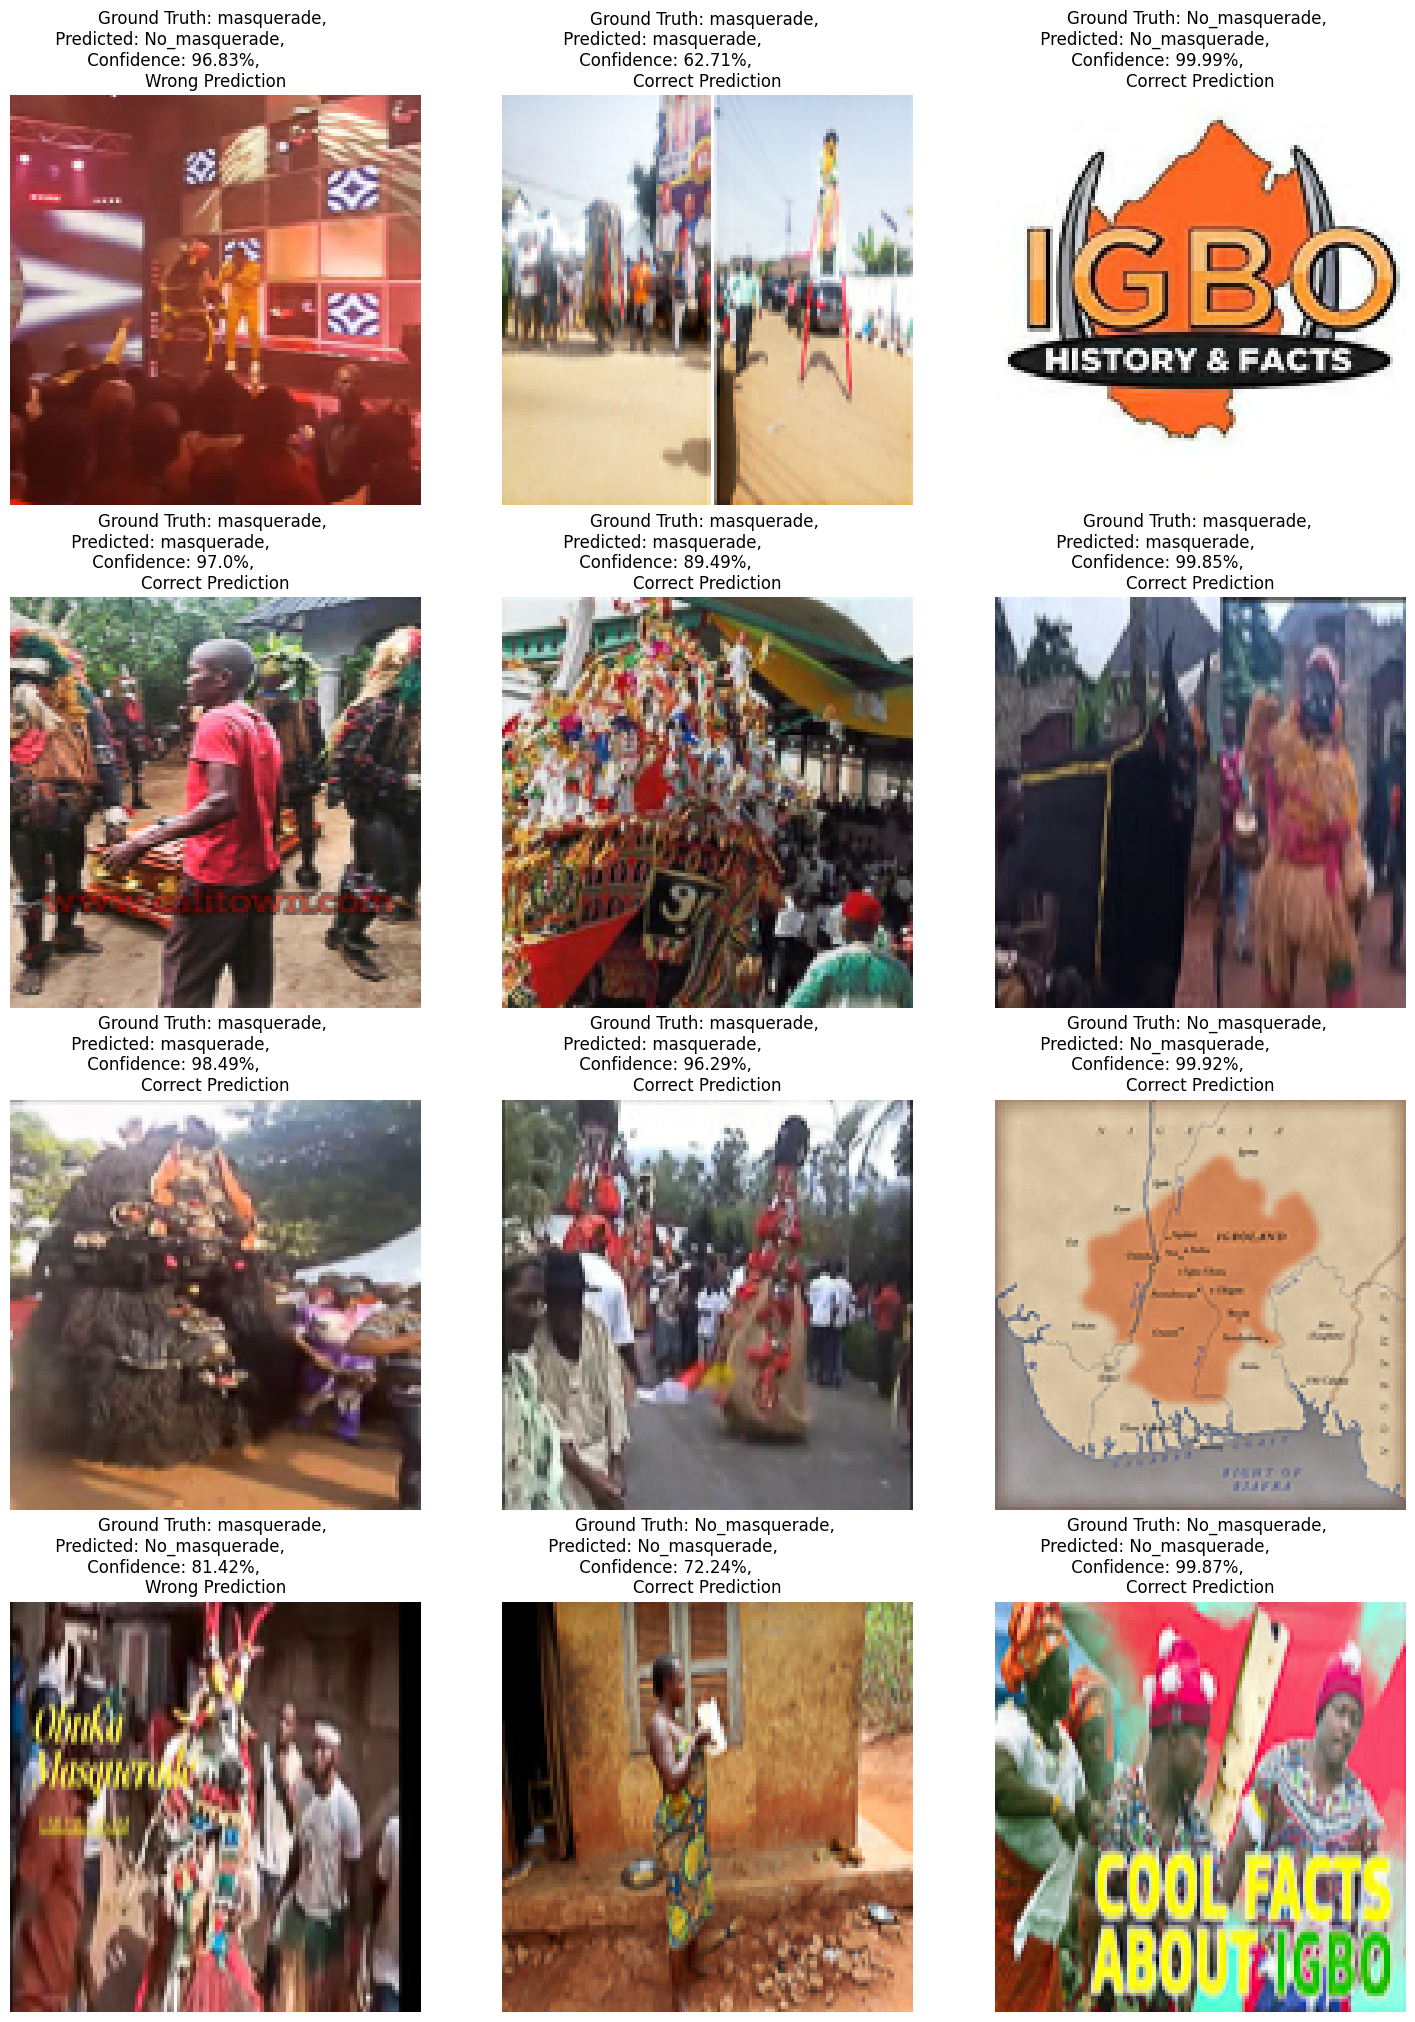

In [22]:
#Test a few examples
plt.figure(figsize=(18,25))

for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        if actual_class==predicted_class:
            Text = 'Correct Prediction'
        else:
            Text = 'Wrong Prediction'
            
        plt.title(f"Ground Truth: {actual_class}, \n Predicted: {predicted_class},\
                  \n Confidence: {confidence}%,\
                 \n{Text}")
        plt.axis("off")
        

In [23]:
#dynamic generation of model version number
model_version = max([int(i) for i in os.listdir('./Model') + [0]]) + 1
model.save(f"./Model/Model_{model_version}.h5")

/Users/ositanwegbu/anaconda3/envs/project1/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
